In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
from urllib.request import urlopen
from json import loads
from tqdm import tqdm

C:\Users\nnguyen2\AppData\Local\Temp\ipykernel_11828\2449311611.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


IPEDS data can be fetched from https://educationdata.urban.org/documentation/colleges.html, which has several types of data into higher education and convenient ways to get data with Python, R, or download.

In [2]:
# get the directory of higher education institutions with basic information
year = 2021
url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/{year}/"
response = urlopen(url)
data = loads(response.read())
directory = pd.json_normalize(data['results'])
directory['unitid']=directory['unitid'].astype(str)
directory.tail()

,year,unitid,inst_name,address,state_abbr,zip,phone_number,city,county_name,offering_highest_level,...,cc_enroll_2018,cc_size_setting_2018,cc_basic_2021,cc_instruc_undergrad_2021,cc_instruc_grad_2021,cc_undergrad_2021,cc_enroll_2021,cc_size_setting_2021,cc_size_setting_2015,url_disability_services
6284,2021,497301,Avalon Institute-Las Vegas,"2650 South Decatur Boulevard Suites 1, 6, 8-10",NV,89102-0046,7024784599,Las Vegas,Clark County,2,...,-1,-1,-2,-2,-2,-2,-2,-2,-1,https://avalon.edu/admissions-process/
6285,2021,497310,Medspa Academies-National Institute of Modern ...,3993 Howard Hughes Parkway Suite 150,NV,89169-6745,8018906835,Las Vegas,Clark County,2,...,-1,-1,-2,-2,-2,-2,-2,-2,-1,https://www.nima.edu/aesthetician-school-near-me/
6286,2021,497329,American Institute-Cherry Hill,2201 Route 38 8th Floor,NJ,08002-4309,8564445600,Cherry Hill,Camden County,2,...,-1,-1,-2,-2,-2,-2,-2,-2,-1,https://www.americaninstitute.com/
6287,2021,497338,Glendale Career College-North-West College-Bak...,3000 Ming Avenue,CA,93304-5075,6614047575,Bakersfield,Kern County,3,...,-1,-1,-2,-2,-2,-2,-2,-2,-1,https://glendalecareercollege.com/
6288,2021,497347,University of Maine - Machias,116 O'Brien Avenue,ME,04654-1397,,Machias,Washington County,-1,...,-1,-1,-2,-2,-2,-2,-2,-2,-1,


In [3]:
# Make a function to get data on the same topic for multiple years
def request_data(url, suffix=''):
    df = pd.DataFrame()
    for year in tqdm(range(1887,2022)):
        try:
            response = urlopen(url+f'{year}{suffix}')
            data = loads(response.read())
            dataframe = pd.json_normalize(data['results'])
            df = pd.concat([df, dataframe], ignore_index = True)
        except:
            df = pd.concat([df,pd.DataFrame()], ignore_index = True)
    return df

In [4]:
# Query finance data
url = "https://educationdata.urban.org/api/v1/college-university/ipeds/finance/"
fin = request_data(url)
fin['unitid'] = fin['unitid'].astype(str)

100%|██████████| 135/135 [04:19<00:00,  1.92s/it]


In [5]:
# Admissions — Applications, admissions, and enrollments
url = "https://educationdata.urban.org/api/v1/college-university/ipeds/admissions-enrollment/"
aae = request_data(url)
aae['unitid'] = aae['unitid'].astype(str)

100%|██████████| 135/135 [00:41<00:00,  3.26it/s]


In [6]:
# Earnings after graduation
earnings = request_data("https://educationdata.urban.org/api/v1/college-university/scorecard/earnings/")
earnings['unitid'] = earnings['unitid'].astype(str)

100%|██████████| 135/135 [00:46<00:00,  2.90it/s]


In [7]:
# Grants and Net Price
gnp = request_data("https://educationdata.urban.org/api/v1/college-university/ipeds/sfa-grants-and-net-price/")
gnp['unitid'] = gnp['unitid'].astype(str)

100%|██████████| 135/135 [00:40<00:00,  3.37it/s]


In [8]:
# This is the alliance data I assembled by myself and not part of IPEDS
aldf = pd.read_csv('G:/My Drive/Career/Presidential Research/Higher Education/institution_data/alliances.csv', dtype={'unitid': str})
len(aldf)

5776

In [9]:
# Create 2 groups, "in alliance" and "standalone"
directory['in_alliance'] = np.where(directory['unitid'].isin(aldf['unitid'].unique()), 1, 0)
directory['in_alliance'].value_counts()


0    4481
1    1808
Name: in_alliance, dtype: int64

In [23]:
in_alliance_sector_count = pd.DataFrame(directory[directory['in_alliance']==1]['sector'].value_counts(normalize=False)).reset_index().rename(columns={'index':'sector', 'sector':'count'})
standalone_sector_count = pd.DataFrame(directory[directory['in_alliance']==0]['sector'].value_counts(normalize=False)).reset_index().rename(columns={'index':'sector', 'sector':'count'})
in_alliance_sector_percentage = pd.DataFrame(directory[directory['in_alliance']==1]['sector'].value_counts(normalize=True)).reset_index().rename(columns={'index':'sector', 'sector':'percentage'})
standalone_sector_percentage = pd.DataFrame(directory[directory['in_alliance']==0]['sector'].value_counts(normalize=True)).reset_index().rename(columns={'index':'sector', 'sector':'percentage'})
table = pd.merge(in_alliance_sector_count, in_alliance_sector_percentage, on='sector', how = 'outer').merge(standalone_sector_count, on='sector', how = 'outer').merge(standalone_sector_percentage, on='sector', how = 'outer')

sector_dict = {0:'administrative unit',1:'public four-year', 2:'private non-profit four-year', 3:'private for-profit four-year', 4:'public two-year', 5:'private non-profit two-year',
               6:'private for-profit two-year', 7:'public less than two-year', 8:'private non-profit less than two-year', 9:'private for-profit less than two-year', -1:'unknown', -2:'not applicable',-3:'suppressed data'}

table['sector'] = table['sector'].astype(int).replace(sector_dict)
in_alliance_table = pd.merge(in_alliance_sector_count, in_alliance_sector_percentage, on='sector')
in_alliance_table['alliance status'] = 'in alliance'
standalone_table = pd.merge(standalone_sector_count, standalone_sector_percentage, on='sector')
standalone_table['alliance status'] = 'standalone'
viz_table = pd.concat([in_alliance_table, standalone_table])
viz_table['sector'] = viz_table['sector'].astype(int).replace(sector_dict)
import plotly.express as px

# Sort the dataframe by percentage for in alliance group in descending order
viz_table_sorted = viz_table.sort_values(by=['percentage'], ascending=True)
# Create a grouped bar chart with custom bar width and opacity
fig = px.bar(viz_table_sorted, x='percentage', y='sector', color='alliance status',text='count',
             color_discrete_map={'standalone': 'lightgrey', 'in alliance': 'green'},
             barmode='group', labels={'percentage': 'Percentage', 'sector': 'Sector', 'count': 'Count'})

# Add custom labels to the bars with larger font size
fig.update_traces(texttemplate='%{text} inst; %{x:.2%}',
                  marker=dict(line=dict(width=3)), # Adjust bar width
                  textfont=dict(size=16)) # Adjust label font size

# Update layout
fig.update_layout(title_text='Sector Distribution by Alliance Status', title_font_size=24,
                  xaxis=dict(title='Percentage within Group', titlefont=dict(size=20), tickfont=dict(size=16), showticklabels=True, tickformat='.0%'),
                  yaxis=dict(title=None, showticklabels=True, ticktext=viz_table_sorted['sector'], tickfont=dict(size=16)),
                  legend=dict(title=None, font=dict(size=20), xanchor='right', x=0.98, yanchor='top', bgcolor='rgba(255,255,255,0.5)', bordercolor='rgba(0,0,0,0.5)', borderwidth=0), # Update legend properties
                  width=1000, # Adjust figure width
                  height=1000) # Adjust figure height

# Show the figure
fig.show()

# Combining Data

In [82]:
# Combining data with SQL
import sqlite3
import pandas as pd
import numpy as np

# Connect to the in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Convert pandas DataFrames to temporary SQL tables
directory.to_sql('directory', conn, index=False)
fin.to_sql('fin', conn, index=False)
aae.to_sql('aae', conn, index=False)
earnings.to_sql('earnings', conn, index=False)
gnp.to_sql('gnp', conn, index=False)
aldf.to_sql('aldf', conn, index=False)

# Standard year where data were most available
year = 2017

# Execute the SQL statements
cursor = conn.cursor()

# Create the merged_directory_gnp table with all the joins and filtering
query = """
WITH directory_grouped AS (
    SELECT directory.*, CASE WHEN directory.unitid IN (SELECT unitid FROM aldf) THEN 1 ELSE 0 END AS in_alliance
    FROM directory
),
merged_directory_finances AS (
    SELECT d.unitid, d.inst_name, d.city, d.state_abbr, d.in_alliance, d.sector, d.inst_category, d.latitude, d.longitude, fin.*
    FROM directory_grouped AS d
    LEFT JOIN fin ON d.unitid = fin.unitid AND fin.year = ?
),
merged_directory_aae AS (
    SELECT merged_directory_finances.*, aae.number_applied, aae.number_admitted, aae.number_enrolled_total
    FROM merged_directory_finances
    LEFT JOIN aae ON merged_directory_finances.unitid = aae.unitid AND aae.year = ? AND aae.sex = 99
),
merged_directory_earnings AS (
    SELECT merged_directory_aae.*, earnings.earnings_mean, earnings.earnings_med
    FROM merged_directory_aae
    LEFT JOIN earnings ON merged_directory_aae.unitid = earnings.unitid AND earnings.year = 2014 AND earnings.cohort_year = 2008
),
merged_directory_gnp AS (
    SELECT merged_directory_earnings.*, gnp.total_grant
    FROM merged_directory_earnings
    LEFT JOIN gnp
    ON merged_directory_earnings.unitid = gnp.unitid
    AND gnp.type_of_aid = 3
    AND gnp.tuition_type = 99
    AND gnp.income_level = 99
    AND gnp.year = ?
)
SELECT * FROM merged_directory_gnp;
"""

# Fetch the results into a new DataFrame
cursor.execute(query, (year, year, year))
results = cursor.fetchall()
columns = [description[0] for description in cursor.description]
df = pd.DataFrame(results, columns=columns)

# Replace -1, -2, -3 with NaN
df.replace([-1, -2, -3], np.nan, inplace=True)

# Commit the changes and close the cursor and connection
conn.commit()
cursor.close()
conn.close()

# Print the resulting DataFrame
df.tail()


,unitid,inst_name,city,state_abbr,in_alliance,sector,inst_category,latitude,longitude,unitid:1,...,heca,est_fte,rep_fte,calc_fte,number_applied,number_admitted,number_enrolled_total,earnings_mean,earnings_med,total_grant
6284,497301,Avalon Institute-Las Vegas,Las Vegas,NV,0,9.0,6.0,36.142355,-115.206409,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6285,497310,Medspa Academies-National Institute of Modern ...,Las Vegas,NV,0,9.0,6.0,36.117236,-115.158173,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6286,497329,American Institute-Cherry Hill,Cherry Hill,NJ,0,9.0,6.0,39.939428,-75.015417,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6287,497338,Glendale Career College-North-West College-Bak...,Bakersfield,CA,0,6.0,4.0,35.339951,-119.035082,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6288,497347,University of Maine - Machias,Machias,ME,0,NaN,NaN,44.708803,-67.458025,None,...,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# Combining data with pandas
# Standard year where data were most available
year = 2017

# Add alliance status column to directory
directory['in_alliance'] = np.where(directory['unitid'].isin(aldf['unitid'].unique()), 1, 0)

# Merge directory and finances
df = pd.merge(directory.drop(columns='year'), fin[fin['year']==year], on=['unitid'], how='left')

# Merge with application-admission-enrollment
aae_yr = aae[(aae['year']==year) & (aae['sex']==99)]
df = df.merge(aae_yr[['unitid', 'number_applied', 'number_admitted','number_enrolled_total']], on='unitid', how='left')
# Merge with earnings after graduation data
earn0814 = earnings[(earnings['year'] == 2014) & (earnings['cohort_year'] == 2008)]
df = df.merge(earn0814[['unitid', 'earnings_mean','earnings_med']], on=['unitid'], how='left')
# Merge with grants and net price data
gnp_fil = gnp[
              (gnp['type_of_aid']==3) # Federal, state, local, or institutional grants
              & (gnp['tuition_type']==99) # 99 means all tuition types
              & (gnp['income_level']==99) # 99 means all income levels
              & (gnp['year']==year)
]

df = df.merge(gnp_fil[['unitid', 'total_grant']], on=['unitid'], how='left')
# Treat missing values as NaN
df = df.replace([-1,-2,-3], np.NaN)
df.tail()


,unitid,inst_name,city,state_abbr,in_alliance,year,fips,rev_tuition_fees_gross,rev_tuition_fees_net,rev_appropriations_fed,...,heca,est_fte,rep_fte,calc_fte,number_applied,number_admitted,number_enrolled_total,earnings_mean,earnings_med,total_grant
6284,497301,Avalon Institute-Las Vegas,Las Vegas,NV,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6285,497310,Medspa Academies-National Institute of Modern ...,Las Vegas,NV,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6286,497329,American Institute-Cherry Hill,Cherry Hill,NJ,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6287,497338,Glendale Career College-North-West College-Bak...,Bakersfield,CA,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6288,497347,University of Maine - Machias,Machias,ME,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Rename levels of sector and category to be more descriptive
sector_dict = {0:'administrative unit',1:'public four-year', 2:'private non-profit four-year', 3:'private for-profit four-year', 4:'public two-year', 5:'private non-profit two-year',
               6:'private for-profit two-year', 7:'public less than two-year', 8:'private non-profit less than two-year', 9:'private for-profit less than two-year', -1:'unknown', -2:'not applicable',-3:'suppressed data'}
category_dict = {1:'degree-granting, graduate with no undergraduate degrees', 2:'degree-granting, primarily baccalaureate or above',
                3:'degree-granting, not primarily baccalaureate or above',4:"degree-granting, associate's and certificates", 
                5:"nondegree-granting, above the baccalaureate", 6:"nondegree-granting, sub-baccalaureate",
                -1:'unknown', -2:'not applicable',-3:'suppressed data'}
df['sector'] = df['sector'].fillna(-1).astype(int).replace(sector_dict)
df['inst_category'] = df['inst_category'].fillna(-1).astype(int).replace(category_dict)

# Prepare more metrics

In [105]:
# Admission rate
df['admission_rate'] = df['number_admitted']/df['number_applied']
# Enrollment rate
df['enrollment_rate'] = df['number_enrolled_total']/df['number_admitted']
# Gifts as percent of total revenue
df['gifts_as_percent_of_total_revenue'] = df['rev_gifts_grants_contracts']/df['rev_total_current']
# Tuition income as percent of total revenue
df['tuition_as_percent_of_total_revenue'] = df['rev_tuition_fees_net']/df['rev_total_current']
# net revenue from auxiliary business as a percentage of total revenue
df['rev_auxiliary_enterprises_net_as_percent_of_total_revenue'] = df['rev_auxiliary_enterprises_net']/df['rev_total_current']
# auxiliary enterprises expenses as a percentage of total expenses
df['exp_auxiliary_enterprises_as_percent_of_total_expenses'] = df['exp_aux_ent_total']/df['exp_total_current']
# total instruction expenses as percentage of total expenses
df['exp_instruc_total_as_percent_of_total_expenses'] = df['exp_instruc_total']/df['exp_total_current']
# Net operating income ratio on auxiliary enterprises
df['net_operating_income_ratio_on_auxiliary_enterprises'] = (df['rev_auxiliary_enterprises_net']-df['exp_aux_ent_total'])/df['exp_aux_ent_total']
# debt_to_assets_ratio
df['debt_to_assets_ratio'] = df['assets']/df['liabilities']
# maintenance and operations expenses as a percentage of total expenses
df['exp_opm_as_percent_of_total_expenses'] = df['exp_total_opm']/df['exp_total_current']
# academic support expense as a percentage of total expenses
df['exp_academic_support_as_percent_of_total_expenses'] = df['exp_acad_supp_total']/df['exp_total_current']
# Total Grant as a percentage of tuition revenue
df['total_grant_as_percent_of_tuition_revenue'] = df['total_grant']/df['rev_tuition_fees_gross']

df=df.replace([np.inf, -np.inf], np.nan)


In [76]:
# Combining to institutions in Alliances
adf = pd.merge(df, aldf[['unitid','system_name']], on = 'unitid', how = 'inner')
adf.head()

,unitid,inst_name,city,state_abbr,in_alliance,latitude,longitude,unitid:1,year,fips,...,tuition_as_percent_of_total_revenue,rev_auxiliary_enterprises_net_as_percent_of_total_revenue,exp_auxiliary_enterprises_as_percent_of_total_expenses,exp_instruc_total_as_percent_of_total_expenses,net_operating_income_ratio_on_auxiliary_enterprises,debt_to_assets_ratio,exp_opm_as_percent_of_total_expenses,exp_academic_support_as_percent_of_total_expenses,total_grant_as_percent_of_tuition_revenue,system_name
0,100654,Alabama A & M University,Normal,AL,1,34.783368,-86.568502,100654,2017.0,1.0,...,0.262199,0.134331,0.075489,0.204457,0.910608,0.909179,0.102325,0.042219,NaN,Association of Public and Land-grant Universities
1,100654,Alabama A & M University,Normal,AL,1,34.783368,-86.568502,100654,2017.0,1.0,...,0.262199,0.134331,0.075489,0.204457,0.910608,0.909179,0.102325,0.042219,NaN,Oak Ridge Associated Universities
2,100654,Alabama A & M University,Normal,AL,1,34.783368,-86.568502,100654,2017.0,1.0,...,0.262199,0.134331,0.075489,0.204457,0.910608,0.909179,0.102325,0.042219,NaN,American Association of State Colleges and Uni...
3,100663,University of Alabama at Birmingham,Birmingham,AL,1,33.505697,-86.799345,100663,2017.0,1.0,...,0.078715,0.013730,0.028578,0.104597,-0.488732,1.463158,0.027791,0.061354,NaN,American Association of Colleges and Universities
4,100663,University of Alabama at Birmingham,Birmingham,AL,1,33.505697,-86.799345,100663,2017.0,1.0,...,0.078715,0.013730,0.028578,0.104597,-0.488732,1.463158,0.027791,0.061354,NaN,Inter-University Consortium for Political and ...


# Mean vs. Median Problem

## 1. Distributions with similar means might have different spreads

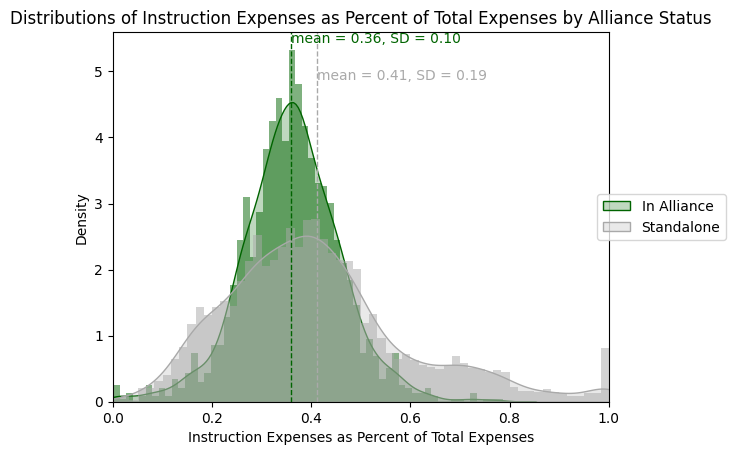

In [109]:
import seaborn as sns
data = df[df['sector'] == 'private non-profit four-year']

group_labels = {0: 'Standalone', 1: 'In Alliance'}
colors = {0: 'darkgrey', 1: 'darkgreen'}

value = 'exp_instruc_total_as_percent_of_total_expenses'
category = 'in_alliance'

# Filter data for each category separately
groups = data[category].unique()

# Create the figure and axes
fig, ax = plt.subplots()

for group in groups:
    group_data = df[df[category] == group][value]
    sns.kdeplot(group_data, color=colors[group], label=group_labels[group], fill=True)
    plt.hist(group_data, bins=60, color=colors[group], alpha=0.5, density=True)

    # Calculate and plot the mean line
    mean_value = group_data.mean()
    std = group_data.std()
    ax.axvline(mean_value, color=colors[group], linestyle='--', linewidth=1)
    ax.text(mean_value, 0.9+group/10, f'mean = {mean_value:.2f}, SD = {std:.2f}', color=colors[group], ha='left', va='top', transform=ax.get_xaxis_transform())

plt.xlabel('Instruction Expenses as Percent of Total Expenses')
plt.xlim(0, 1)
plt.ylabel('Density')
# Position the legend in the middle right edge
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.title('Distributions of Instruction Expenses as Percent of Total Expenses by Alliance Status')

plt.show()


In [ ]:
# skewness per alliance status
import numpy as np
from scipy.stats import skew, kurtosis

variable = 'exp_instruc_total_as_percent_of_total_expenses'
print('Skewness of Instruction Expenses as Percent of Total Expenses by Alliance Status')
print('In Alliance: ', skew(data[data['in_alliance'] == 1][variable].dropna()))
print('Standalone: ', skew(data[data['in_alliance'] == 0][variable].dropna()))

# kurtosis per alliance status
print('Kurtosis of Instruction Expenses as Percent of Total Expenses by Alliance Status')
print('In Alliance: ', kurtosis(data[data['in_alliance'] == 1][variable].dropna()))
print('Standalone: ', kurtosis(data[data['in_alliance'] == 0][variable].dropna()))

Skewness of Instruction Expenses as Percent of Total Expenses by Alliance Status
In Alliance:  0.11504005296544793
Standalone:  0.6369647382617045
Kurtosis of Instruction Expenses as Percent of Total Expenses by Alliance Status
In Alliance:  1.234653689042628
Standalone:  0.9922689017924342


## 2. Skewness shifts distance between mean and median

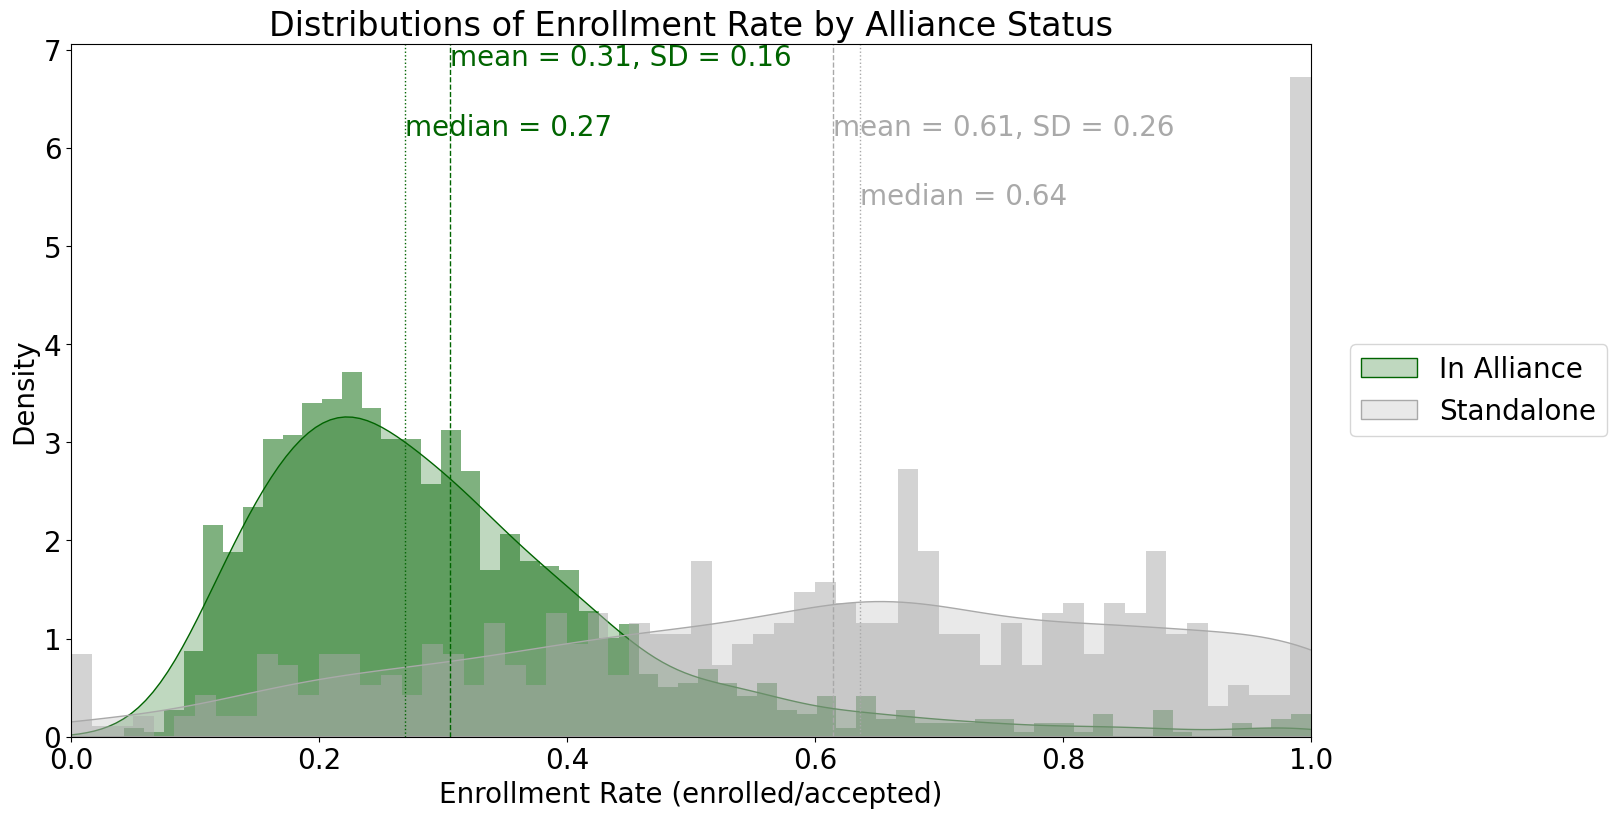

In [106]:
import seaborn as sns
data = df[df['sector'] == 'private non-profit four-year']

group_labels = {0: 'Standalone', 1: 'In Alliance'}
colors = {0: 'darkgrey', 1: 'darkgreen'}

value = 'enrollment_rate'
category = 'in_alliance'

# Filter data for each category separately
groups = data[category].unique()

# Create the figure and axes with a 16:9 aspect ratio
fig, ax = plt.subplots(figsize=(16, 9))

for group in groups:
    group_data = df[df[category] == group][value]
    sns.kdeplot(group_data, color=colors[group], label=group_labels[group], fill=True)
    plt.hist(group_data, bins=60, color=colors[group], alpha=0.5, density=True)

    # Calculate and plot the mean line
    mean_value = group_data.mean()
    std = group_data.std()
    ax.axvline(mean_value, color=colors[group], linestyle='--', linewidth=1)
    ax.text(mean_value, 0.9+group/10, f'mean = {mean_value:.2f}, SD = {std:.2f}', color=colors[group], ha='left', va='top', transform=ax.get_xaxis_transform(), fontsize=20)

    # Calculate and plot the median line
    median_value = group_data.median()
    ax.axvline(median_value, color=colors[group], linestyle=':', linewidth=1)
    ax.text(median_value, 0.8+group/10, f'median = {median_value:.2f}', color=colors[group], ha='left', va='top', transform=ax.get_xaxis_transform(), fontsize=20)

plt.xlabel('Enrollment Rate (enrolled/accepted)', fontsize=20)
plt.ylabel('Density', fontsize=20)
# make x and y ticker bigger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Distributions of Enrollment Rate by Alliance Status', fontsize=24)
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
# Position the legend in the middle right edge
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=20)

plt.show()


## 3. Comparing Mean and Median Earnings After Graduation among Private Non-Profit Four-Year Institutions

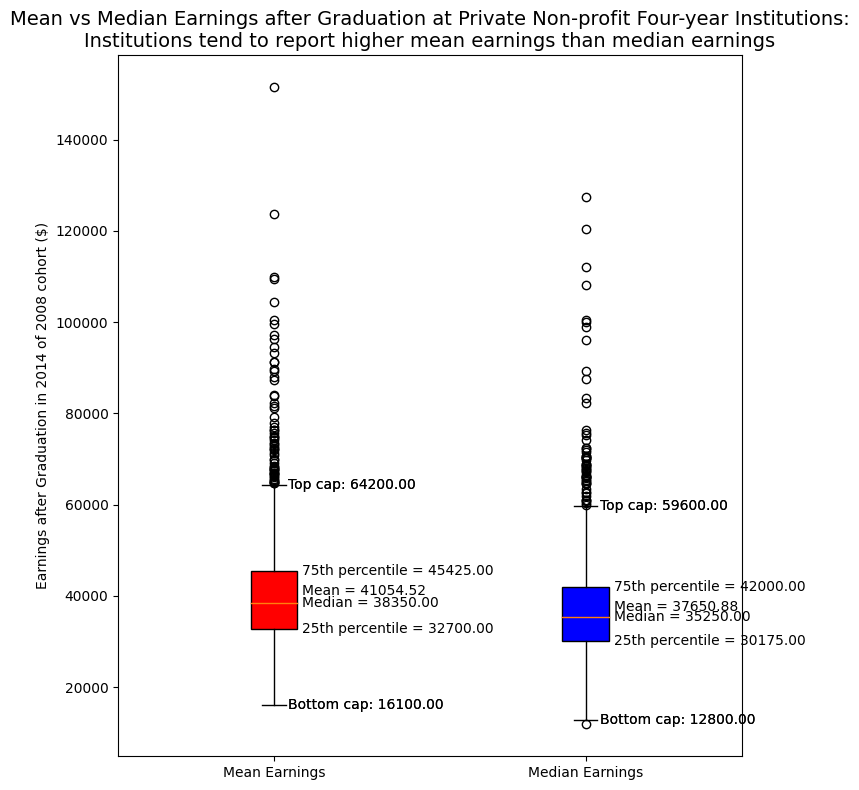

In [100]:
# Filter for private non-profit four-year institutions
data = df[df['sector'] == 'private non-profit four-year'].reset_index(drop=True)

# Mean vs Med earnings after graduation boxplots
fig, ax = plt.subplots(figsize=(8,8))
columns=['earnings_mean','earnings_med']
series = [data[column].dropna() for column in columns]

boxplot = ax.boxplot(series, labels=['Mean Earnings', 'Median Earnings'], patch_artist=True)

colors = ['red', 'blue']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Earnings after Graduation in 2014 of 2008 cohort ($)')

# Grab the relevant Line2D instances from the boxplot dictionary
medians = boxplot['medians']
caps = boxplot['caps']

for i, median in enumerate(medians):
    xpos = median.get_xdata()
    xoff = 0.10 * (xpos[1] - xpos[0])
    xlabel = xpos[1] + xoff
    median_y = median.get_ydata()[0]
    ax.text(xlabel, median_y, 'Median = {:.2f}'.format(median_y), va='center')

    # Add labels for 25th and 75th percentiles
    q1 = np.percentile(series[i], 25)
    q3 = np.percentile(series[i], 75)
    ax.text(xlabel, q1, '25th percentile = {:.2f}'.format(q1), va='center')
    ax.text(xlabel, q3, '75th percentile = {:.2f}'.format(q3), va='center')

    # Add labels for top cap and bottom cap
    for cap in caps:
        xpos = cap.get_xdata()
        xoff = 0.10 * (xpos[1] - xpos[0])
        xlabel = xpos[1] + xoff
        cap_y = cap.get_ydata()[0]
        if cap_y < median_y:
            ax.text(xlabel, cap_y, 'Bottom cap: {:.2f}'.format(cap_y), va='center')
        else:   
            ax.text(xlabel, cap_y, 'Top cap: {:.2f}'.format(cap_y), va='center')

# Calculate and display the mean for each boxplot
for i, column in enumerate(columns):
    mean = np.mean(series[i])
    xpos = medians[i].get_xdata()
    xoff = 0.10 * (xpos[1] - xpos[0])
    xlabel = xpos[1] + xoff
    ax.text(xlabel, mean, 'Mean = {:.2f}'.format(mean), va='center')

# Add title:
plt.title('Mean vs Median Earnings after Graduation at Private Non-profit Four-year Institutions:\nInstitutions tend to report higher mean earnings than median earnings', fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\nnguyen2\AppData\Local\Temp\ipykernel_11828\3622771810.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mean-Median Difference')


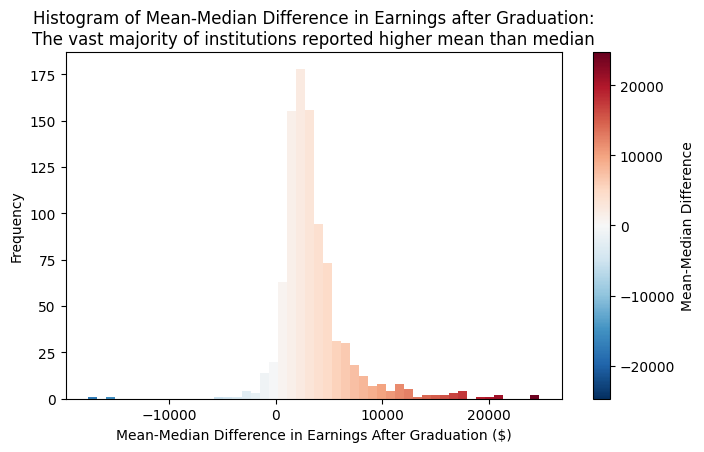

In [103]:
# create "mean_med_diff" column that is earnings_mean - earnings_med
data['mean_med_diff'] = data['earnings_mean'] - data['earnings_med']

import numpy as np
import matplotlib.pyplot as plt

# Create a red-blue colormap that diverges at 0, reversed so that red is higher values
cmap = plt.cm.get_cmap('RdBu_r')
norm = plt.Normalize(vmin=-max(abs(data['mean_med_diff'])), vmax=max(abs(data['mean_med_diff'])))

# Set the figsize
fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot the histogram using bars
n, bins, patches = plt.hist(data['mean_med_diff'], bins=50)

# Set the color for each patch based on x-axis values
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colors = cmap(norm(bin_centers))

# Set the color for each patch
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Set the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Mean-Median Difference')

# Set the axis labels and title
plt.xlabel('Mean-Median Difference in Earnings After Graduation ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Mean-Median Difference in Earnings after Graduation:\nThe vast majority of institutions reported higher mean than median')

# Show the plot
plt.show()

